In [1]:
import numpy as np

from IPython.display import clear_output
from matplotlib import pyplot as plt

from timeit import default_timer as timer
from datetime import timedelta

import math
import random

from qutip import Bloch, Bloch3d, basis
from qutip.qip.operations import rz

from qutip.operators import sigmax, sigmay, sigmaz
from qutip.qip.operations import snot
from qutip import basis, expect

# Local imports

from spectator_env_v2 import SpectatorEnvContinuousV2

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def context_loss(meas, trans):
    return np.var([np.pi - np.arccos(
        np.sqrt(t.overlap(meas) * meas.overlap(t))) for t in trans])


def correction_loss(meas, trans):
    return np.mean([np.pi - np.arccos(
        np.sqrt(t.overlap(meas) * meas.overlap(t))) for t in trans])


def get_contour(error_samples, loss_fn):
    prepared_basis = [snot() * basis(2, 0), snot() * sigmax() * basis(2, 0)]
    trans = [rz(sample) * prepared_basis[0] for sample in error_samples]

    thetas = np.linspace(-np.pi, np.pi, 33)
    phis = np.linspace(-np.pi, np.pi, 33)
    loss = np.zeros((len(thetas), len(phis)))

    min_phi = 0.
    min_theta = 0.
    min_loss = 1.

    max_phi = 0.
    max_theta = 0.
    max_loss = 0.
    for i, theta in enumerate(thetas):
        for j, phi in enumerate(phis):
            meas = np.cos(theta / 2) * prepared_basis[0] + np.exp(
                1j * phi) * np.sin(theta / 2) * prepared_basis[1]
            meas = meas.unit()

            objective = loss_fn(meas, trans)
            if (np.abs(objective) < min_loss):
                min_loss = objective
                min_phi = phi
                min_theta = theta
            if (np.abs(objective) > max_loss):
                max_loss = objective
                max_phi = phi
                max_theta = theta
            loss[i][j] = np.abs(objective)
    return {'thetas': thetas, 'phis': phis, 'loss': loss, 'max_phi': max_phi, 'max_theta': max_theta}

In [4]:
def plot(axs, frame_idx, elapsed_time, baseline_fidelity=None,
         corrected_fidelity=None,  context_theta_history=None,
         correction_theta_history=None, context_outcome_hist=None,
         context_contour=None, correction_contour=None, correction_grads=None):

    if correction_theta_history:
        axs[0].set_title('Correction phase space (gradient steps)')
        for k, v in correction_theta_history.items():
            alphas = np.linspace(0.1, 1, len(v))
            rgba_colors = np.zeros((len(v), 4))
            rgba_colors[:, 1] = 1 - k
            rgba_colors[:, 2] = k
            rgba_colors[:, 3] = alphas
            axs[0].scatter([x[1] for x in v], [x[0] for x in v], c=rgba_colors,
                           label=k)

        axs[0].legend()

    if context_theta_history:
        alphas = np.linspace(0.1, 1, len(context_theta_history))
        rgba_colors = np.zeros((len(context_theta_history), 4))
        rgba_colors[:, 2] = 1.0
        rgba_colors[:, 3] = alphas

        axs[1].set_title('Context phase space (gradient steps)')
        axs[1].scatter([x[1] for x in context_theta_history],
                       [x[0] for x in context_theta_history], c=rgba_colors)

    if context_contour and context_theta_history:
        thetas = context_contour['thetas']
        phis = context_contour['phis']
        loss = context_contour['loss']
        r, theta = np.meshgrid(len(thetas), len(phis))
        axs[2].contourf(phis, thetas, loss, alpha=0.5)

        alphas = np.linspace(0.1, 1, len(context_theta_history))
        rgba_colors = np.zeros((len(context_theta_history), 4))
        rgba_colors[:, 2] = 1.0
        rgba_colors[:, 3] = alphas

        axs[2].set_title('Context phase space (gradient steps)')
        axs[2].scatter([x[1] for x in context_theta_history],
                       [x[0] for x in context_theta_history], c=rgba_colors)

    if correction_contour and correction_theta_history:
        thetas = correction_contour[0]['thetas']
        phis = correction_contour[0]['phis']
        loss = correction_contour[0]['loss']
        r, theta = np.meshgrid(len(thetas), len(phis))
        axs[3].contourf(phis, thetas, loss, alpha=0.5)

        axs[3].set_title('Context 0: Correction phase space (gradient steps)')
        alphas = np.linspace(0.1, 1, len(v))
        rgba_colors = np.zeros((len(v), 4))
        rgba_colors[:, 2] = 1
        rgba_colors[:, 3] = alphas
        axs[3].scatter([x[1] for x in correction_theta_history[0]],
                       [x[0] for x in correction_theta_history[0]],
                       c=rgba_colors)

        thetas = correction_contour[1]['thetas']
        phis = correction_contour[1]['phis']
        loss = correction_contour[1]['loss']
        r, theta = np.meshgrid(len(thetas), len(phis))
        axs[4].contourf(phis, thetas, loss, alpha=0.5)

        axs[4].set_title('Context 1: Correction phase space (gradient steps)')
        alphas = np.linspace(0.1, 1, len(v))
        rgba_colors = np.zeros((len(v), 4))
        rgba_colors[:, 2] = 1
        rgba_colors[:, 3] = alphas
        axs[4].scatter([x[1] for x in correction_theta_history[1]],
                       [x[0] for x in correction_theta_history[1]],
                       c=rgba_colors)

    if baseline_fidelity and corrected_fidelity:
        axs[5].set_title('Fidelity (per episode)')
        axs[5].plot(corrected_fidelity, 'g', label='corrected')
        axs[5].plot(baseline_fidelity, 'r', label='uncorrected')
        axs[5].legend()

    if context_outcome_hist:
        max_k = 0
        for k, v in context_outcome_hist.items():
            axs[6].hist(v, label=k)
            max_k = max(k, max_k)
            axs[6].legend()
        axs[6].set_title('Distribution of contextual outcomes (all episodes)')

        axs[7].set_title('Distribution of contextual outcomes (most recent episode)')
        axs[7].hist(context_outcome_hist[max_k])

    if correction_grads:
        axs[8].plot([g[0] for g in correction_grads[0]], label='theta_1')
        axs[8].plot([g[1] for g in correction_grads[0]], label='theta_2')
        axs[8].plot([g[2] for g in correction_grads[0]], label='theta_3')
        axs[8].set_title('Gradient')
        axs[8].legend()

        axs[9].plot([g[0] for g in correction_grads[1]], label='theta_1')
        axs[9].plot([g[1] for g in correction_grads[1]], label='theta_2')
        axs[9].plot([g[2] for g in correction_grads[1]], label='theta_3')
        axs[9].set_title('Gradient')
        axs[9].legend()

In [5]:
# (action, reward) distribution for a given "spectator measurement outcome" state
class Context:
    def __init__(self, gamma, eta, correction_theta_init):
        # discount factor
        self.gamma = gamma
        self.eta = eta

        self.batch_correction_feedback = ([], [], [])
        self.correction_theta = correction_theta_init

        self.grads = [0, 0, 0]

    def reset(self):
        self.batch_correction_feedback = ([], [], [])

    def discount(self):
        pass

    def update_gamma(self, gamma):
        self.gamma = gamma

    def update_batch_feedback(self, correction_feedback, idx):
        self.batch_correction_feedback[idx].append(correction_feedback)

    def get_and_combine_optimal_theta(self):
        if len(self.batch_correction_feedback[0]) == 0:
            return self.correction_theta, self.grads

        # feedback is given per variational param
        grads = [0, 0, 0]
        for idx, f in enumerate(self.batch_correction_feedback):
            lo = np.array([r[0] for r in f])
            hi = np.array([r[2] for r in f])
            lo = np.array(list(map(lambda x: -1 if x == 0 else 1, lo.flatten())))
            hi = np.array(list(map(lambda x: -1 if x == 0 else 1, hi.flatten())))
#             print("lo", lo, "hi", hi)

            mu_plus = np.mean(hi)
            mu_minus = np.mean(lo)

            grad = mu_plus - mu_minus

#             print('l/h', lo, hi)
#             print(grad, mu_plus, mu_minus)

            self.correction_theta[idx] -= self.eta * grad
            self.grads[idx] = grad

        self.reset()

        return self.correction_theta, grads

    def get_optimal_theta(self):
        return self.correction_theta

In [6]:
# contextual analytic geometric descent
class Analytic2D:
    def __init__(self, env, initial_gamma=0.99, context_eta=np.pi/64,
                 correction_eta=np.pi/64, context_theta_init=[0, 0, 0],
                 correction_theta_init=[[0, 0, 0], [0, 0, 0]]):
        # two contexts -> pos vs neg rotation with respect to a chosen
        # rotational basis
        self.contexts = [Context(initial_gamma, correction_eta,
                                 correction_theta_init[0]),
                         Context(initial_gamma, correction_eta,
                                 correction_theta_init[1])]

        self.rewards = []
        self.fidelity = []
        self.control_fidelity = []

        self.num_context_spectators = env.num_context_spectators
        self.num_reward_spectators = env.num_reward_spectators

        # step size
        self.eta = context_eta

        self.batch_context_feedback = ([], [], [])
        self.context_theta = context_theta_init

    def get_actions(self, observations=None, batch_size=1):
        # Our context is an array of binary spectator qubit measurements.
        # Hence, we could convert this binary array to an integer and index
        # 2^(spectator qubits) contexts.
        # For now, we only have two contexts (+ vs -), and so we consider
        # spectators to be indistinguishable noise polling devices.
        # In the future, we may consider noise gradients and so we do indeed
        # need to track the specific arrangement.

        if observations is None:
            return [{'context': self.context_theta} for i in range(batch_size)]

        actions = []
        for observation in observations:
            context_idx = 1 if np.sum(observation) > self.num_context_spectators / 2 else 0
            context = self.contexts[context_idx]

            # (theta vec)
            if len(self.batch_context_feedback[0]) != 0:
                for idx, f in enumerate(self.batch_context_feedback):
                    lo =  np.array([r[0] for r in f])
                    mid = np.array([r[1] for r in f])
                    hi = np.array([r[2] for r in f])

                    lo = np.array(list(map(lambda x: -1 if x == 0 else 1, lo.flatten())))
                    mid = np.array(list(map(lambda x: -1 if x == 0 else 1, mid.flatten())))
                    hi = np.array(list(map(lambda x: -1 if x == 0 else 1, hi.flatten())))

                    mu = np.mean(mid)
                    var_grad = np.mean([2 * (m - mu) * np.abs(h - l)
                                        for l, m, h in zip(lo, mid, hi)])

                    self.context_theta[idx] += self.eta * var_grad
                self.batch_context_feedback = ([], [], [])

            optimal_theta, grad = context.get_and_combine_optimal_theta()
            actions.append(
                {'correction': optimal_theta,
                 'correction_grad': grad,
                 'context': self.context_theta})
        return actions

    def update(self, context_feedback, correction_feedback, observations):
        for context in self.contexts:
            context.reset()

        # feedback is given per theta
        for idx in range(len(self.context_theta)):
            for _context_feedback, _correction_feedback, observation in zip(
                    context_feedback[idx], correction_feedback[idx], observations):
                context_idx = 1 if np.sum(observation) > self.num_context_spectators / 2 else 0
                context = self.contexts[context_idx]
                context.update_batch_feedback(_correction_feedback, idx)

                self.batch_context_feedback[idx].append(_context_feedback)

    def _update_gammas(self, gamma):
        for context in self.contexts:
            context.update_gamma(gamma)

    def save_reward(self, reward):
        self.rewards.append(reward)

    def save_fidelity(self, fidelity):
        self.fidelity.append(fidelity)

    def save_control_fidelity(self, fidelity):
        self.control_fidelity.append(fidelity)

In [7]:
M = 100
BATCH_SIZE = 100

MU = 0
SIGMA = np.pi / 4

# add some random harmonics
# time_dependent_fn = np.vectorize(lambda x: (2/5) * np.pi * np.sin(2 * np.pi * x / M))
# error_samples = np.random.normal(MU, SIGMA, M) # + time_dependent_fn(np.arange(M))
# error_samples = np.random.choice([-np.pi/2, np.pi / 2], M)
error_samples = np.random.uniform(-np.pi/2, np.pi/2, M)

In [8]:
# describes MDP
# - states are given in terms of a #context_spectators bit measurement outcomes
# - continuous action space is given by ([-pi, pi], smoothing parameter, contextual_measurement_bias) i.e. \U(1) \times U(1) \times U(1)
env = SpectatorEnvContinuousV2(error_samples, batch_size=BATCH_SIZE,
                               num_context_spectators=12, num_reward_spectators=12,
                               context_sensitivity=1.0, reward_sensitivity=1.0)

In [9]:
def extract_theta_phi(single_qubit_gate):
    # apply gate to |+>
    ket = single_qubit_gate * snot() * basis(2, 0)

    alpha = ket.full()[0][0]
    beta = ket.full()[1][0]
    # rewrite in x-basis
    ket_raw = [(alpha + beta) / 2, (alpha - beta) / 2]
    ket_raw = ket_raw / np.linalg.norm(ket_raw)

    theta = 0
    phi = 0

    if ket_raw[0] * ket_raw[0].conj() < 1e-6:
        theta = np.pi
        phi = 0
    elif ket_raw[1] * ket_raw[1].conj() < 1e-6:
        theta = 0
        phi = 0
    else:
        theta = 2 * np.arccos(np.sqrt(ket_raw[0] * ket_raw[0].conj()))
        phi = np.angle(ket_raw[0].conj() * ket_raw[1] / (
            np.sqrt(ket_raw[0] * ket_raw[0].conj()) * np.sqrt(ket_raw[1] * ket_raw[1].conj())))

    return theta, phi

In [10]:
context_contour = get_contour(error_samples, context_loss)

In [11]:
print(context_contour['max_phi'], context_contour['max_theta'])

-1.5707963267948966 -1.5707963267948966


In [12]:
import copy

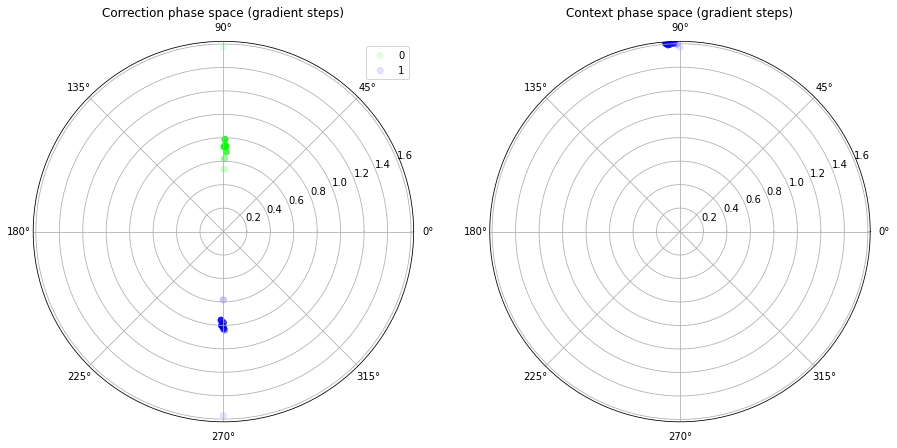

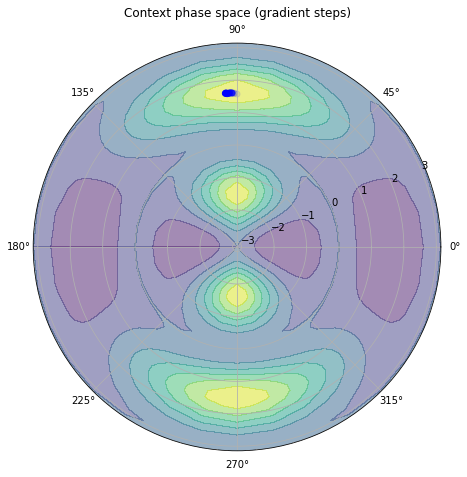

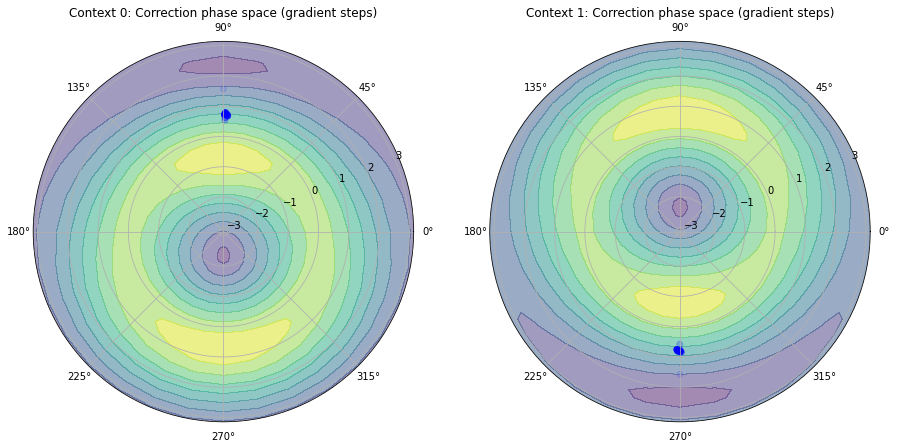

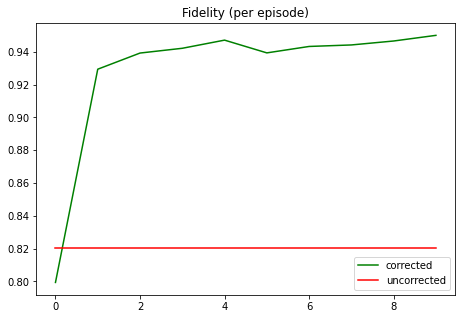

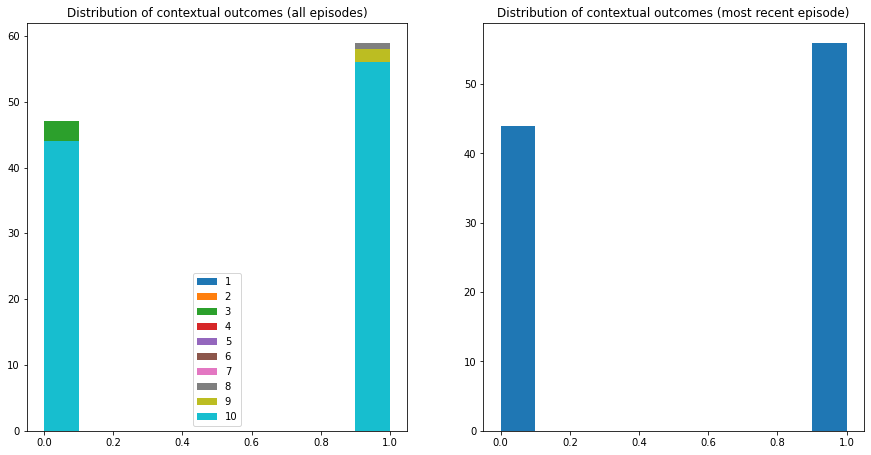

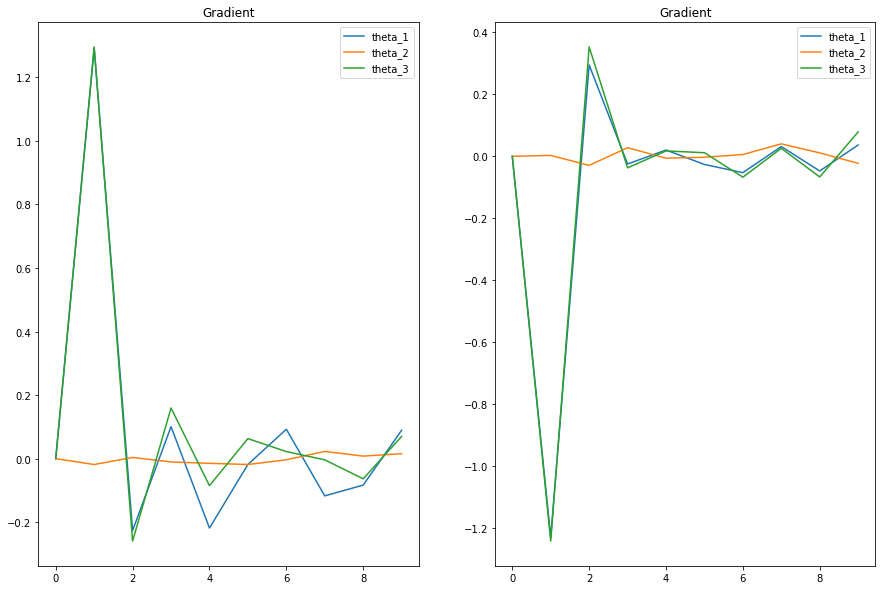

In [ ]:
start = timer()

md = Analytic2D(env, initial_gamma=1.0, context_eta=np.pi / 16,
                correction_eta=np.pi / 8, context_theta_init=[0, 0,
                                                               0],
                correction_theta_init=[[0, 0, 0],
                                       [0, 0, 0]])

episode_fidelity = []
control_fidelity = []

MAX_FRAMES = 100 * M // BATCH_SIZE
UPDATE_ERROR_SAMPLES_FRAMES = M // BATCH_SIZE

# "episodes" are a reasonable way to think about learning a periodic
# time-dependent function.
# max frames = episode length * num episodes
# episodes are identical sequences of training data
init_actions = md.get_actions(batch_size=BATCH_SIZE)
observation = env.reset(init_actions)

correction_2d_repr = {}
context_2d_repr = []

correction_grads = {}

# context outcomes per episode
context_outcome_hist = {}

for frame_idx in range(1, MAX_FRAMES + 1):
    epoch = frame_idx // (M // BATCH_SIZE)

    actions = md.get_actions(observation)
    prev_batch = env.error_samples_batch
    prev_observation = copy.deepcopy(observation)
    observation, feedback, done, info = env.step(actions)
    observation = None if done else observation

    for obs in prev_observation:
        context_outcome = 1 if np.sum(obs) > env.num_context_spectators / 2 else 0
        if epoch in context_outcome_hist.keys():
            context_outcome_hist[epoch].append(context_outcome)
        else:
            context_outcome_hist[epoch] = [context_outcome]

    # generally, in RL we would consider r(s | s', a)
    # given a state transition s' -> s due to action a
    # for now, we are only interested in r(s', a)
    md.update(context_feedback=feedback['batched_context_feedback'],
              correction_feedback=feedback['batched_correction_feedback'],
              observations=prev_observation)

    for x, y in info:
        episode_fidelity.append(x)
        control_fidelity.append(y)

#     if UPDATE_ERROR_SAMPLES_FRAMES:
#         new_error_samples = np.random.normal(MU, SIGMA, M)
#         env.set_error_samples(new_error_samples)

    context_2d_repr.append(extract_theta_phi(
        env._get_correction(md.context_theta)))
    for idx, c in enumerate(md.contexts):
        correction_2d = extract_theta_phi(
                env._get_correction(c.correction_theta))
        if idx in correction_2d_repr.keys():
            correction_2d_repr[idx].append(correction_2d)
        else:
            correction_2d_repr[idx] = [correction_2d]

    grads_0 = np.mean([a['correction_grad'] for a in np.array(actions)[[
                np.sum(obs) <= env.num_context_spectators / 2 for obs in prev_observation]]],
                    axis=0)
    if 0 in correction_grads.keys():
        correction_grads[0].append(grads_0)
    else:
        correction_grads[0] = [grads_0]

    grads_1 = np.mean([a['correction_grad'] for a in np.array(actions)[[
                np.sum(obs) > env.num_context_spectators / 2 for obs in prev_observation]]],
                    axis=0)
    if 1 in correction_grads.keys():
        correction_grads[1].append(grads_1)
    else:
        correction_grads[1] = [grads_1]

    if done:
        md.save_fidelity(np.mean(episode_fidelity))
        md.save_control_fidelity(np.mean(control_fidelity))
        episode_fidelity = []
        control_fidelity = []

        correction_contour = {}
        correction_contour[0] = get_contour(prev_batch[
            [np.sum(obs) <= env.num_context_spectators / 2 for obs in prev_observation]], correction_loss)
        correction_contour[1] = get_contour(prev_batch[
            [np.sum(obs) > env.num_context_spectators / 2 for obs in prev_observation]], correction_loss)

        observation = env.reset(actions)

        clear_output(True)
        _, axs = plt.subplots(1, 2, figsize=(15, 10),
                              subplot_kw=dict(polar=True))
        _, axs_context_contour = plt.subplots(1, 1, figsize=(7.5, 7.5),
                                              subplot_kw=dict(polar=True))
        _, axs_correction_contour = plt.subplots(1, 2, figsize=(15, 10),
                                                 subplot_kw=dict(polar=True))
        _, ax_fid = plt.subplots(1, 1, figsize=(7.5, 5))
        _, ax_hist = plt.subplots(1, 2, figsize=(15, 7.5))
        _, axs_correction_grad = plt.subplots(1, 2, figsize=(15, 10))
        plot(np.concatenate((axs, [axs_context_contour], axs_correction_contour,
                             [ax_fid], ax_hist, axs_correction_grad)), frame_idx,
             timedelta(seconds=int(timer()-start)),
             baseline_fidelity=md.control_fidelity,
             corrected_fidelity=md.fidelity,
             context_theta_history=context_2d_repr,
             correction_theta_history=correction_2d_repr,
             correction_contour=correction_contour,
             context_outcome_hist=context_outcome_hist,
             context_contour=context_contour,
             correction_grads=correction_grads)
        plt.show()

env.close()

